# Notebook 1: Data Ingestion & Initial Processing

**Purpose**: Load raw dataset, handle missing values, remove duplicates, perform basic sanity checks, and normalize labels.

**Outputs**:
- `cleaned_data.csv` → `data/processed/`
- `data_summary.json` → `results/`

---

In [1]:
# Imports
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Paths
BASE_DIR = Path('.').resolve().parent
RAW_DATA_DIR = BASE_DIR / 'data' / 'raw'
PROCESSED_DIR = BASE_DIR / 'data' / 'processed'
RESULTS_DIR = BASE_DIR / 'results'

# Create directories if they don't exist
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Base Directory: {BASE_DIR}")
print(f"Raw Data Directory: {RAW_DATA_DIR}")

Base Directory: C:\Users\mostr\OneDrive\Documents\GitHub\Proj\Anomaly-detection-in-finance-using-QML
Raw Data Directory: C:\Users\mostr\OneDrive\Documents\GitHub\Proj\Anomaly-detection-in-finance-using-QML\data\raw


## 1. Load Raw Dataset

In [2]:
# Load the credit card fraud dataset
raw_file = RAW_DATA_DIR / 'creditcard.csv'

print(f"Loading data from: {raw_file}")
df_raw = pd.read_csv(raw_file)

print(f"\nDataset Shape: {df_raw.shape}")
print(f"Columns: {list(df_raw.columns)}")

Loading data from: C:\Users\mostr\OneDrive\Documents\GitHub\Proj\Anomaly-detection-in-finance-using-QML\data\raw\creditcard.csv

Dataset Shape: (284807, 31)
Columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


In [3]:
# Basic info
print("Dataset Info:")
print("=" * 50)
df_raw.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 

In [4]:
# Statistical summary
df_raw.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


## 2. Handle Missing Values

In [5]:
# Check for missing values
missing_counts = df_raw.isnull().sum()
missing_pct = (missing_counts / len(df_raw)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_counts,
    'Missing %': missing_pct
})

print("Missing Values Summary:")
print(missing_df[missing_df['Missing Count'] > 0])

if missing_df['Missing Count'].sum() == 0:
    print("\n✅ No missing values found!")

Missing Values Summary:
Empty DataFrame
Columns: [Missing Count, Missing %]
Index: []

✅ No missing values found!


In [6]:
# Handle missing values (if any)
df_clean = df_raw.dropna()
rows_dropped = len(df_raw) - len(df_clean)
print(f"Rows dropped due to missing values: {rows_dropped}")

Rows dropped due to missing values: 0


## 3. Remove Duplicates

In [7]:
# Check for duplicates
duplicates_count = df_clean.duplicated().sum()
print(f"Duplicate rows found: {duplicates_count}")

# Remove duplicates
df_clean = df_clean.drop_duplicates()
print(f"Shape after removing duplicates: {df_clean.shape}")

Duplicate rows found: 1081
Shape after removing duplicates: (283726, 31)


## 4. Basic Sanity Checks

In [8]:
# Target column analysis
TARGET_COLUMN = 'Class'

print("Target Column Distribution (Full Dataset):")
print("=" * 50)
target_counts = df_clean[TARGET_COLUMN].value_counts()
target_pct = df_clean[TARGET_COLUMN].value_counts(normalize=True) * 100

print(f"Normal (0): {target_counts[0]:,} ({target_pct[0]:.4f}%)")
print(f"Fraud (1):  {target_counts[1]:,} ({target_pct[1]:.4f}%)")
print(f"\nClass Imbalance Ratio: 1:{target_counts[0]/target_counts[1]:.1f}")

Target Column Distribution (Full Dataset):
Normal (0): 283,253 (99.8333%)
Fraud (1):  473 (0.1667%)

Class Imbalance Ratio: 1:598.8


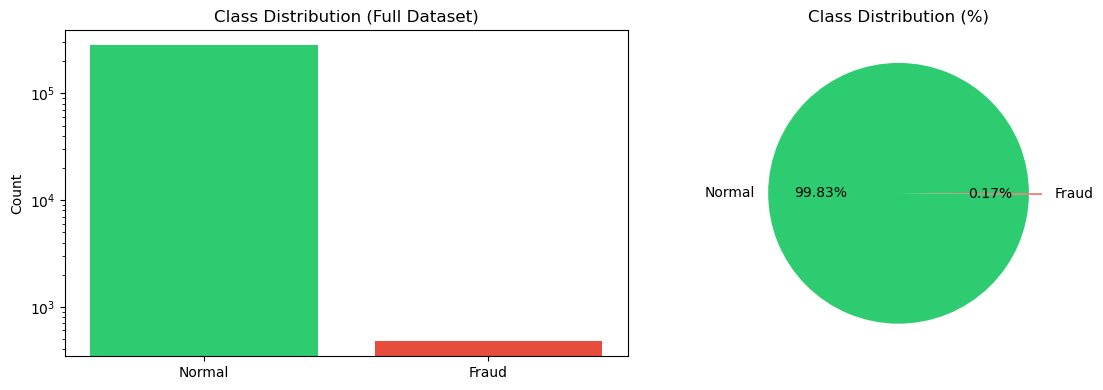

In [9]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Bar plot
colors = ['#2ecc71', '#e74c3c']
ax1 = axes[0]
ax1.bar(['Normal', 'Fraud'], [target_counts[0], target_counts[1]], color=colors)
ax1.set_ylabel('Count')
ax1.set_title('Class Distribution (Full Dataset)')
ax1.set_yscale('log')

# Pie chart
ax2 = axes[1]
ax2.pie([target_counts[0], target_counts[1]], labels=['Normal', 'Fraud'], 
        autopct='%1.2f%%', colors=colors, explode=[0, 0.1])
ax2.set_title('Class Distribution (%)')

plt.tight_layout()
plt.savefig(RESULTS_DIR.parent / 'figures' / 'class_distribution_raw.png', dpi=150)
plt.show()

In [10]:
# Data type checks
print("Data Types:")
print(df_clean.dtypes)

Data Types:
Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object


## 5. Stratified Subsampling (2000 samples with ~5% anomalies)

In [11]:
# Configuration
MAX_SAMPLES = 2000
TARGET_ANOMALY_RATIO = 0.05  # 5% anomalies

# Calculate sample sizes
n_anomalies = int(MAX_SAMPLES * TARGET_ANOMALY_RATIO)  # 100 anomalies
n_normal = MAX_SAMPLES - n_anomalies  # 1900 normal

print(f"Target samples: {MAX_SAMPLES}")
print(f"Normal samples: {n_normal}")
print(f"Anomaly samples: {n_anomalies}")
print(f"Target anomaly ratio: {TARGET_ANOMALY_RATIO*100}%")

Target samples: 2000
Normal samples: 1900
Anomaly samples: 100
Target anomaly ratio: 5.0%


In [12]:
# Separate classes
df_normal = df_clean[df_clean[TARGET_COLUMN] == 0]
df_fraud = df_clean[df_clean[TARGET_COLUMN] == 1]

print(f"Available normal samples: {len(df_normal)}")
print(f"Available fraud samples: {len(df_fraud)}")

Available normal samples: 283253
Available fraud samples: 473


In [13]:
# Stratified sampling
np.random.seed(RANDOM_SEED)

# Sample normal class
df_normal_sampled = df_normal.sample(n=n_normal, random_state=RANDOM_SEED)

# Sample fraud class (use all if less than required, else sample)
if len(df_fraud) <= n_anomalies:
    df_fraud_sampled = df_fraud.copy()
    print(f"⚠️ Using all {len(df_fraud)} fraud samples (less than target {n_anomalies})")
else:
    df_fraud_sampled = df_fraud.sample(n=n_anomalies, random_state=RANDOM_SEED)

# Combine
df_subsampled = pd.concat([df_normal_sampled, df_fraud_sampled], ignore_index=True)

# Shuffle
df_subsampled = df_subsampled.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

print(f"\nSubsampled dataset shape: {df_subsampled.shape}")


Subsampled dataset shape: (2000, 31)


In [14]:
# Verify subsample distribution
print("Subsampled Dataset Distribution:")
print("=" * 50)
sub_counts = df_subsampled[TARGET_COLUMN].value_counts()
sub_pct = df_subsampled[TARGET_COLUMN].value_counts(normalize=True) * 100

print(f"Normal (0): {sub_counts[0]:,} ({sub_pct[0]:.2f}%)")
print(f"Fraud (1):  {sub_counts[1]:,} ({sub_pct[1]:.2f}%)")

Subsampled Dataset Distribution:
Normal (0): 1,900 (95.00%)
Fraud (1):  100 (5.00%)


## 6. Label Normalization

In [15]:
# Ensure labels are 0 and 1
assert set(df_subsampled[TARGET_COLUMN].unique()) == {0, 1}, "Labels should be 0 and 1"
print("✅ Labels are already normalized (0 = Normal, 1 = Anomaly)")

✅ Labels are already normalized (0 = Normal, 1 = Anomaly)


## 7. Save Outputs

In [16]:
# Save cleaned data
output_path = PROCESSED_DIR / 'cleaned_data.csv'
df_subsampled.to_csv(output_path, index=False)
print(f"✅ Saved cleaned data to: {output_path}")

✅ Saved cleaned data to: C:\Users\mostr\OneDrive\Documents\GitHub\Proj\Anomaly-detection-in-finance-using-QML\data\processed\cleaned_data.csv


In [17]:
# Create and save data summary
# Convert numpy types to native Python types for JSON serialization
data_summary = {
    "source_file": str(raw_file),
    "original_shape": list(df_raw.shape),
    "cleaned_shape": list(df_subsampled.shape),
    "random_seed": int(RANDOM_SEED),
    "target_column": TARGET_COLUMN,
    "class_distribution": {
        "normal_count": int(sub_counts[0]),
        "anomaly_count": int(sub_counts[1]),
        "normal_percentage": float(round(sub_pct[0], 2)),
        "anomaly_percentage": float(round(sub_pct[1], 2))
    },
    "features": {
        "total": int(len(df_subsampled.columns) - 1),
        "names": [col for col in df_subsampled.columns if col != TARGET_COLUMN]
    },
    "missing_values_dropped": int(rows_dropped),
    "duplicates_dropped": int(duplicates_count),
    "preprocessing_steps": [
        "Loaded raw creditcard.csv",
        "Dropped missing values",
        "Removed duplicates",
        f"Stratified subsampling to {MAX_SAMPLES} samples",
        f"Target anomaly ratio: {TARGET_ANOMALY_RATIO*100}%"
    ]
}

summary_path = RESULTS_DIR / 'data_summary.json'
with open(summary_path, 'w') as f:
    json.dump(data_summary, f, indent=2)

print(f"✅ Saved data summary to: {summary_path}")

✅ Saved data summary to: C:\Users\mostr\OneDrive\Documents\GitHub\Proj\Anomaly-detection-in-finance-using-QML\results\data_summary.json


In [18]:
# Display summary
print("\nData Summary:")
print("=" * 50)
print(json.dumps(data_summary, indent=2))


Data Summary:
{
  "source_file": "C:\\Users\\mostr\\OneDrive\\Documents\\GitHub\\Proj\\Anomaly-detection-in-finance-using-QML\\data\\raw\\creditcard.csv",
  "original_shape": [
    284807,
    31
  ],
  "cleaned_shape": [
    2000,
    31
  ],
  "random_seed": 42,
  "target_column": "Class",
  "class_distribution": {
    "normal_count": 1900,
    "anomaly_count": 100,
    "normal_percentage": 95.0,
    "anomaly_percentage": 5.0
  },
  "features": {
    "total": 30,
    "names": [
      "Time",
      "V1",
      "V2",
      "V3",
      "V4",
      "V5",
      "V6",
      "V7",
      "V8",
      "V9",
      "V10",
      "V11",
      "V12",
      "V13",
      "V14",
      "V15",
      "V16",
      "V17",
      "V18",
      "V19",
      "V20",
      "V21",
      "V22",
      "V23",
      "V24",
      "V25",
      "V26",
      "V27",
      "V28",
      "Amount"
    ]
  },
  "missing_values_dropped": 0,
  "duplicates_dropped": 1081,
  "preprocessing_steps": [
    "Loaded raw creditcard.csv"

## 8. Verification

In [19]:
# Verify saved file
df_verify = pd.read_csv(PROCESSED_DIR / 'cleaned_data.csv')
print(f"Verification - Loaded shape: {df_verify.shape}")
print(f"Verification - Class distribution: {df_verify[TARGET_COLUMN].value_counts().to_dict()}")
print("\n✅ Notebook 1 Complete!")

Verification - Loaded shape: (2000, 31)
Verification - Class distribution: {0: 1900, 1: 100}

✅ Notebook 1 Complete!
